In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from lmfit.models import VoigtModel, LinearModel
from numpy import sqrt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

class XRDAnalyzer:
    def __init__(self, x_data, y_data):
        self.x = np.array(x_data)
        self.y = np.array(y_data)
        self.y_smooth = None
        self.peaks = None
        self.model = None
        self.params = None
        self.result = None
        self.fwhm_df = None


    def smooth_data(self, sigma=2.0):
        """
        ガウシアンカーネルを用いてデータを平滑化する。

        Parameters:
        - sigma (float): ガウス関数の標準偏差。値が大きいほど強いスムージングが適用されます。
        """
        self.y_smooth = gaussian_filter1d(self.y, sigma=sigma)

    def detect_peaks(self):
        # データの振幅範囲に基づいて prominence を設定
        range_y = np.max(self.y_smooth) - np.min(self.y_smooth)
        prominence = range_y * 0.05  # 振幅範囲の5%

        # データ長に基づいて distance を設定
        distance = int(len(self.y_smooth) * 0.01)  # データ長の1%

        peaks, _ = find_peaks(self.y_smooth, prominence=prominence, distance=distance)
        self.peaks = peaks

    def build_model(self):
        self.model = LinearModel(prefix='bg_')
        self.params = self.model.make_params(intercept=0.5, slope=0.01)
        for i, peak_idx in enumerate(self.peaks):
            prefix = f"v{i}_"
            peak_model = VoigtModel(prefix=prefix)
            self.model += peak_model
            xc = self.x[peak_idx]
            yc = self.y_smooth[peak_idx]
            self.params.update(peak_model.make_params(
                amplitude=yc,
                center=xc,
                sigma=0.2,
                gamma=0.2
            ))

    def fit_model(self):
        self.result = self.model.fit(self.y, self.params, x=self.x)

    def calculate_fwhm(self):
        def voigt_fwhm(sigma, gamma):
            return 0.5346 * 2 * gamma + sqrt(0.2166 * (2 * gamma)**2 + (2.3548 * sigma)**2)

        fwhm_results = []
        for key in self.result.params.keys():
            if key.endswith('center'):
                prefix = key[:-6]
                sigma = self.result.params[f'{prefix}sigma'].value
                gamma = self.result.params[f'{prefix}gamma'].value
                center = self.result.params[f'{prefix}center'].value
                amplitude = self.result.params[f'{prefix}amplitude'].value
                fwhm = voigt_fwhm(sigma, gamma)
                fwhm_results.append((prefix, center, fwhm, amplitude))
        self.fwhm_df = pd.DataFrame(fwhm_results, columns=["Peak", "Center (2θ)", "FWHM (deg)", "Amplitude"])

    def plot_results(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.x, self.y, label='Raw Data', alpha=0.5)
        plt.plot(self.x, self.y_smooth, label='Smoothed', linestyle='--', alpha=0.7)
        plt.plot(self.x, self.result.best_fit, label='Fitted Curve', linewidth=2)
        plt.scatter(self.x[self.peaks], self.y_smooth[self.peaks], color='red', label='Detected Peaks')
        plt.legend()
        plt.xlabel("2θ (degrees)")
        plt.ylabel("Intensity (a.u.)")
        plt.title("Voigt Fitting with Automatic Peak Detection")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def display_fwhm(self):
        print(self.fwhm_df)

    def analyze(self):
        self.smooth_data()
        self.detect_peaks()
        self.build_model()
        self.fit_model()
        self.calculate_fwhm()
        self.plot_results()
        self.display_fwhm()


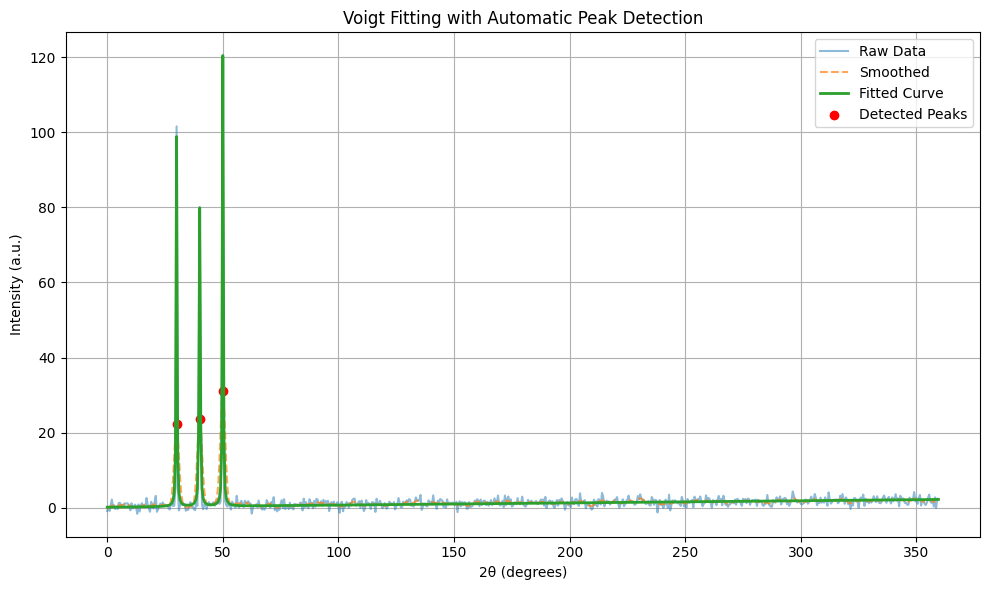

  Peak  Center (2θ)  FWHM (deg)  Amplitude
0  v0_    30.000715    0.400009  61.895281
1  v1_    40.004119    0.650124  70.335702
2  v2_    50.014163    0.400002  75.753320


In [37]:
x = np.arange(0,360,0.5)
noise_level = 0.9
true_y = (
            100 * np.exp(-(x - 30)**2 / (2 * 0.2**2)) +
            80 * np.exp(-(x - 40)**2 / (2 * 0.3**2)) +
            120 * np.exp(-(x - 50)**2 / (2 * 0.25**2)) +
            0.5 + 0.004 * x
        )
y = true_y + np.random.normal(0, noise_level, size=x.size)

analyzer = XRDAnalyzer(x_data=x,y_data=y)
analyzer.analyze()